In [25]:
print('Ну типа тут вступление должно быть')

Ну типа тут вступление должно быть


In [26]:
from tqdm import tqdm
from os import system

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys

In [27]:
sns.set(style='darkgrid', font_scale=2, palette='Set1')

In [28]:
def prepare_drawing(xlabel, ylabel, title):
    plt.figure(figsize=(12, 8))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [29]:
def calculate_result(graph_size, seed=0):    
    !./generate_graph.sh {graph_size} {seed}
    res = !./run.sh
    if len(res) != 1:
        print(graph_size, seed, res)
        sys.stdout.flush()
        
    return int(res[0])

In [30]:
results = []

for graph_size in tqdm(range(2, 1000)):
    results.append(calculate_result(graph_size) / graph_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [20:58<00:00,  1.26s/it]


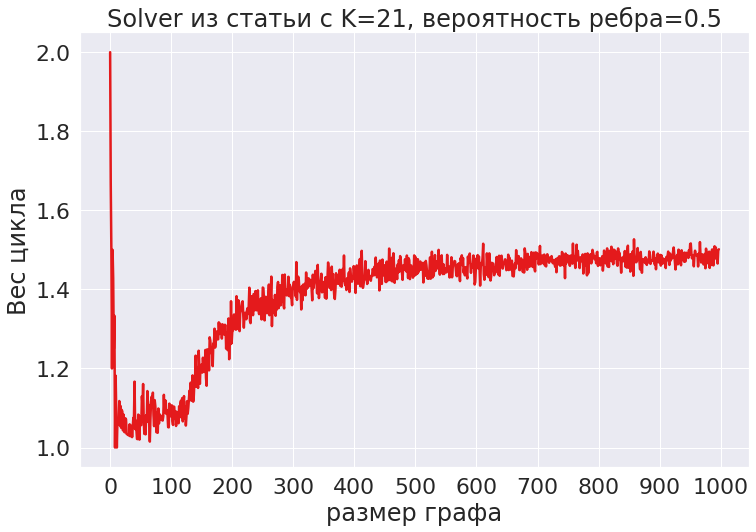

In [43]:
prepare_drawing('размер графа', 'Вес цикла', 'Solver из статьи с K=21, вероятность ребра=0.5')

step = 100
plt.xticks(np.arange(0, len(results) + step, step))

sns.lineplot(data=results, linewidth=2.5);

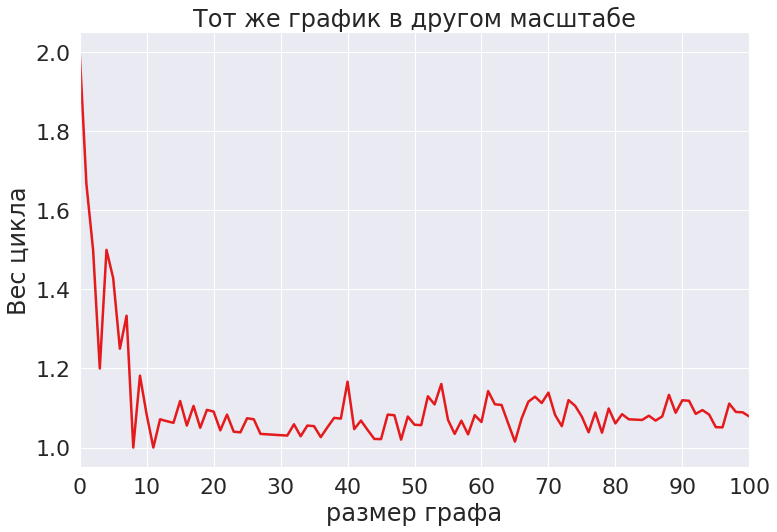

In [45]:
prepare_drawing('размер графа', 'Вес цикла', 'Тот же график в другом масштабе')

step = 10
plt.xticks(np.arange(0, len(results) + step, step))

sns.lineplot(data=results, linewidth=2.5);
plt.xlim((0, 100));

In [41]:

import pandas as pd

df = pd.DataFrame(np.array(results))
 
df.to_csv("original_solver_approximation_k21.csv")

In [33]:

#results = np.genfromtxt('original_solver_approximation_k5.csv', delimiter=',')[:, 1]

In [34]:
results

[2.0,
 1.6666666666666667,
 1.5,
 1.2,
 1.5,
 1.4285714285714286,
 1.25,
 1.3333333333333333,
 1.0,
 1.1818181818181819,
 1.0833333333333333,
 1.0,
 1.0714285714285714,
 1.0666666666666667,
 1.0625,
 1.1176470588235294,
 1.0555555555555556,
 1.105263157894737,
 1.05,
 1.0952380952380953,
 1.0909090909090908,
 1.0434782608695652,
 1.0833333333333333,
 1.04,
 1.0384615384615385,
 1.0740740740740742,
 1.0714285714285714,
 1.0344827586206897,
 1.0333333333333334,
 1.032258064516129,
 1.03125,
 1.0303030303030303,
 1.0588235294117647,
 1.0285714285714285,
 1.0555555555555556,
 1.054054054054054,
 1.0263157894736843,
 1.0512820512820513,
 1.075,
 1.0731707317073171,
 1.1666666666666667,
 1.0465116279069768,
 1.0681818181818181,
 1.0444444444444445,
 1.0217391304347827,
 1.0212765957446808,
 1.0833333333333333,
 1.0816326530612246,
 1.02,
 1.0784313725490196,
 1.0576923076923077,
 1.0566037735849056,
 1.1296296296296295,
 1.1090909090909091,
 1.1607142857142858,
 1.0701754385964912,
 1.034482

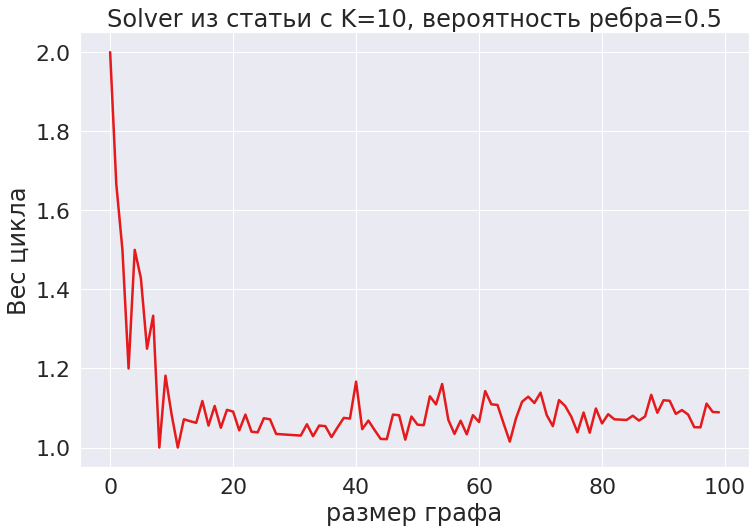

In [35]:
prepare_drawing('размер графа', 'Вес цикла', 'Solver из статьи с K=10, вероятность ребра=0.5')
#plt.xticks(np.arange(0, len(results) + 1, 5))
#plt.yticks(np.arange(0, len(results) + 1, 5))
sns.lineplot(data=results[:100], linewidth=2.5);